# SQLAlchemy Analysis

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import matplotlib.dates as mdates

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Inspect columns types for measurements table
inspector = inspect(engine)
columns_msrt = inspector.get_columns('measurement')
for column in columns_msrt:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Inspect columns type for station tables
columns_st = inspector.get_columns('station')
for column in columns_st:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create session (link) from Python to the DB
session = Session(bind = engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_unpacked= last_date[0]
print(f"The Last Date Reported is {last_date_unpacked}")

The Last Date Reported is 2017-08-23


In [13]:
# Calculate the date 1 year ago from the last data point in the database
one_year_before_date = dt.datetime.strptime(last_date_unpacked, '%Y-%m-%d').date() - dt.timedelta(days = 365)
print( f" Date from one year ago is : {one_year_before_date}")

 Date from one year ago is : 2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
measurement_data = session.query(*sel).filter(Measurement.date >= one_year_before_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(measurement_data, columns=['Date', 'Precipitation'])
measurement_df["Date"]= pd.to_datetime(measurement_df["Date"])
measurement_df.set_index('Date', inplace=True, )
measurement_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [15]:
# Sort the dataframe by date
sorted_measurement_df= measurement_df.sort_index()
sorted_measurement_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


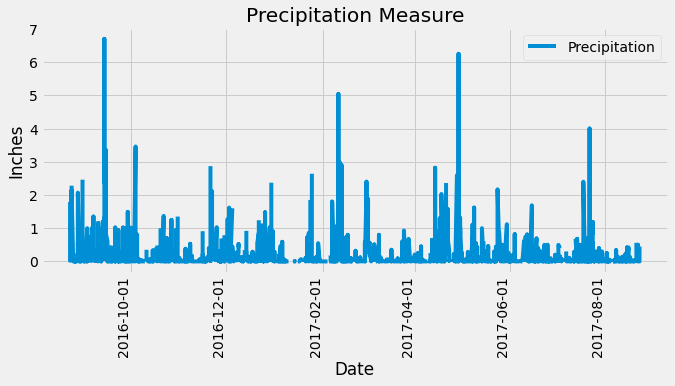

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = sorted_measurement_df.plot(rot=90, figsize = (10,5), x_compat=True);
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_title("Precipitation Measure");
ax.set_ylabel("Inches");



In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_measurement_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station.station).count()
print( f" There are {total_stations} stations in the Dataset")

 There are 9 stations in the Dataset


In [19]:
# A query to show stations
stations_show = session.query(Station.name,Station.station).all()

stations_list = []
for st in stations_show:
    stations_list.append(st[0])
stations_list

['WAIKIKI 717.2, HI US',
 'KANEOHE 838.1, HI US',
 'KUALOA RANCH HEADQUARTERS 886.9, HI US',
 'PEARL CITY, HI US',
 'UPPER WAHIAWA 874.3, HI US',
 'WAIMANALO EXPERIMENTAL FARM, HI US',
 'WAIHEE 837.5, HI US',
 'HONOLULU OBSERVATORY 702.2, HI US',
 'MANOA LYON ARBO 785.2, HI US']

In [20]:
# Query the most active station
# List the stations and the counts in descending order.

sel = [Measurement.station, func.count(Measurement.station)]
most_active_stations = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Station with the highest number of temperature observations.
most_active_st = most_active_stations[0][0]
most_active_st

'USC00519281'

In [22]:
# calculate temperature normals (Tmax, Tmin, Tavg) for the "most active station (most_active_st)"

sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

most_active_records = session.query(*sel).filter(Measurement.station == most_active_st).all()
most_active_records


[(54.0, 85.0, 71.66378066378067)]

In [23]:
# Query the last 12 months of temperature observation data for most_active_st

last_year_most_active_st = session.query(Measurement.tobs).filter(Measurement.date >= one_year_before_date).\
                        filter(Measurement.station == most_active_st).all()
list_active_st_ly= list(np.ravel(last_year_most_active_st))
list_active_st_ly

[77.0,
 77.0,
 80.0,
 80.0,
 75.0,
 73.0,
 78.0,
 77.0,
 78.0,
 80.0,
 80.0,
 78.0,
 78.0,
 78.0,
 73.0,
 74.0,
 80.0,
 79.0,
 77.0,
 80.0,
 76.0,
 79.0,
 75.0,
 79.0,
 78.0,
 79.0,
 78.0,
 78.0,
 76.0,
 74.0,
 77.0,
 78.0,
 79.0,
 79.0,
 77.0,
 80.0,
 78.0,
 78.0,
 78.0,
 77.0,
 79.0,
 79.0,
 79.0,
 79.0,
 75.0,
 76.0,
 73.0,
 72.0,
 71.0,
 77.0,
 79.0,
 78.0,
 79.0,
 77.0,
 79.0,
 77.0,
 78.0,
 78.0,
 78.0,
 78.0,
 77.0,
 74.0,
 75.0,
 76.0,
 73.0,
 76.0,
 74.0,
 77.0,
 76.0,
 76.0,
 74.0,
 75.0,
 75.0,
 75.0,
 75.0,
 71.0,
 63.0,
 70.0,
 68.0,
 67.0,
 77.0,
 74.0,
 77.0,
 76.0,
 76.0,
 75.0,
 76.0,
 75.0,
 73.0,
 75.0,
 73.0,
 75.0,
 74.0,
 75.0,
 74.0,
 75.0,
 73.0,
 75.0,
 73.0,
 73.0,
 74.0,
 70.0,
 72.0,
 70.0,
 67.0,
 67.0,
 69.0,
 70.0,
 68.0,
 69.0,
 69.0,
 66.0,
 65.0,
 68.0,
 62.0,
 75.0,
 70.0,
 69.0,
 76.0,
 76.0,
 74.0,
 73.0,
 71.0,
 74.0,
 74.0,
 72.0,
 71.0,
 72.0,
 74.0,
 69.0,
 67.0,
 72.0,
 70.0,
 64.0,
 63.0,
 63.0,
 62.0,
 70.0,
 70.0,
 62.0,
 62.0,
 63.0,
 65.0,

Text(0, 0.5, 'Frecuency')

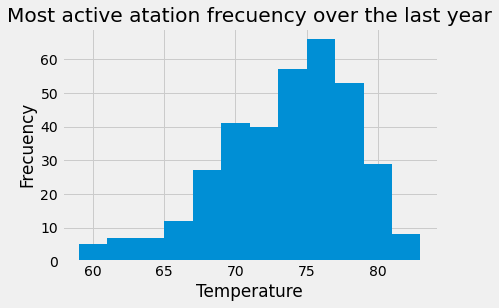

In [24]:
# histogram of the most active st frecuency during the last year
plt.hist(list_active_st_ly, bins=12)
plt.title("Most active atation frecuency over the last year")
plt.xlabel('Temperature')
plt.ylabel('Frecuency')

## Bonus Challenge Assignment

Temperature Analysis I : June & December temperature analysis

In [25]:
# reading csv files using pandas read function

data_file = os.path.join("Resources","hawaii_measurements.csv")
hawaii_df = pd.read_csv(data_file)
hawaii_df["date"]= pd.to_datetime(hawaii_df["date"])
hawaii_df

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73
...,...,...,...,...
19545,USC00516128,2017-08-19,0.09,71
19546,USC00516128,2017-08-20,NaN,78
19547,USC00516128,2017-08-21,0.56,76
19548,USC00516128,2017-08-22,0.50,76


In [26]:
# Identify the average temperature in June at all stations across all available years in the dataset.
date_str_june = "06"
hawaii_filtered_june = hawaii_df.loc[hawaii_df["date"].dt.strftime("%m") == date_str_june ]
hawaii_filtered_avg_june = hawaii_filtered_june["tobs"].mean()
print( F" The average temperature in Hawaii across all stations during June is {round(hawaii_filtered_avg_june,0)}")

 The average temperature in Hawaii across all stations during June is 75.0


In [27]:
# Identify the average temperature in December at all stations across all available years in the dataset.
date_str_dec = "12"
hawaii_filtered_dec = hawaii_df.loc[hawaii_df["date"].dt.strftime("%m") == date_str_dec ]
hawaii_filtered_avg_dec = hawaii_filtered_dec["tobs"].mean()
print( F" The average temperature in Hawaii across all stations during December is {round(hawaii_filtered_avg_dec,0)}")

 The average temperature in Hawaii across all stations during December is 71.0


T-TEST ANALYSIS TO TEST THE STATISTICALLY SIGNIFICANCE OF JUNE AND DECEMBER TOBS

For this part of the analysis an unpaired t-test was used, due that we are comparing the means of two independent groups that comes from different populations (June/December) to determine if there is a significant difference between both of them.

*The null hypothesis (H0) : there is no significant difference between the means of the June and December "TOBS" groups.

*The alternative hypothesis (H1): there is a significant difference between both June and December groups.

In [28]:
stats.ttest_ind(hawaii_filtered_june["tobs"], hawaii_filtered_dec["tobs"])

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

Based on the above result, where the pvalue is less than alpha (0.05), we can say that there is a statistically significance, so we can reject the null hypthesis (H0).

Temperature Analysis II

A function to calculate the min, avg, and max temperatures for the trip using the matching dates from the previous year.

In [29]:
# Defining starting trip date
start_vacation_date = "2018-05-14"

# Calculating last year equivalent date
last_year_start_date = dt.datetime.strptime(start_vacation_date, '%Y-%m-%d').date() - dt.timedelta(days = 365)

# Calculating the total days of vacations
last_year_end_date = (last_year_start_date + dt.timedelta(days = 14))
print(f" Last year vacations were from {last_year_start_date} to {last_year_end_date}")


 Last year vacations were from 2017-05-14 to 2017-05-28


In [30]:
# Converting dates to string
ly_start_date = last_year_start_date.strftime("%Y-%m-%d")
ly_end_date =  last_year_end_date.strftime("%Y-%m-%d")
ly_end_date

'2017-05-28'

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use `calc_temps` to calculate the tmin, tavg, and tmax 
# for the trip , using the previous year's data for those same dates.
tmin, tavg, tmax = calc_temps(ly_start_date, ly_end_date)[0]
print(F" TMIN = {tmin}, TAVG = {round(tavg,1)}, TMAX = {tmax}")

 TMIN = 68.0, TAVG = 74.9, TMAX = 87.0


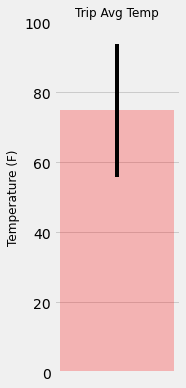

In [33]:
# Plot previous query results as a bar chart.
yerr = tmax - tmin
fig, ax = plt.subplots(figsize=(2,6))
ax.bar(1,tavg,width = 0.2, color = "r", yerr = yerr, alpha = 0.25)
ax.xaxis.set_visible(False)
plt.title("Trip Avg Temp", fontsize = 12)
plt.ylabel("Temperature (F)", fontsize = 12)
plt.ylim(0,100)
plt.show()

In [34]:
# Calculate the total amount of rainfall per weather station trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_sel = [Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation]
ly_rainfall_per_station = session.query(*rainfall_sel).group_by(Measurement.station).\
                        filter(Measurement.station==Station.station).filter(Measurement.date >= last_year_start_date).\
                        filter(Measurement.date <= last_year_end_date).order_by(func.sum(Measurement.prcp).desc()).all()
ly_rainfall_per_station

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  6.25,
  21.3331,
  -157.8025,
  152.4),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  1.68,
  21.33556,
  -157.71139,
  19.5),
 ('USC00513117', 'KANEOHE 838.1, HI US', 1.57, 21.4234, -157.8015, 14.6),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  1.2300000000000002,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.53,
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  0.4600000000000001,
  21.2716,
  -157.8168,
  3.0)]

In [35]:
# Creating a dataframe with previous query results, sorting in descending order by Rainfall Amount
rainfall_amount_df= pd.DataFrame(ly_rainfall_per_station,
             columns=["Station","Station Name", "Rainfall Amount", "Latitude", "Longitude", "Elevation"]
            ).sort_values("Rainfall Amount",ascending=False)
rainfall_amount_df

,Station,Station Name,Rainfall Amount,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",6.25,21.33310,-157.80250,152.4
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",1.68,21.33556,-157.71139,19.5
2,USC00513117,"KANEOHE 838.1, HI US",1.57,21.42340,-157.80150,14.6
3,USC00519281,"WAIHEE 837.5, HI US",1.23,21.45167,-157.84889,32.9
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.53,21.52130,-157.83740,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",0.46,21.27160,-157.81680,3.0


In [36]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [37]:
# calculate the daily normals for the trip

# Set the start and end date of the trip in "%m-%d" format
start_trip_date = last_year_start_date.strftime("%m-%d")
end_trip_date = last_year_end_date.strftime("%m-%d")

print(f" Vacation days are from {start_trip_date} to {end_trip_date}")


 Vacation days are from 05-14 to 05-28


In [38]:
# Use the start and end date to create a range of dates
numdays = 15
date_list = [(last_year_end_date)- dt.timedelta(days=x) for x in range(numdays)]

# Stip off the year and save a list of %m-%d strings
trip_dates = []
trip_ydates = []
for date in date_list:
    trip_dates.append(date.strftime("%m-%d"))
    trip_ydates.append(date.strftime("%Y-%m-%d"))
trip_dates

['05-28',
 '05-27',
 '05-26',
 '05-25',
 '05-24',
 '05-23',
 '05-22',
 '05-21',
 '05-20',
 '05-19',
 '05-18',
 '05-17',
 '05-16',
 '05-15',
 '05-14']

In [39]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for trip_date in trip_dates:
    trip_results = daily_normals(trip_date)
    normals.append(trip_results[0])
normals

[(67.0, 74.27777777777777, 82.0),
 (65.0, 74.49090909090908, 80.0),
 (65.0, 74.03636363636363, 82.0),
 (68.0, 74.27586206896552, 79.0),
 (67.0, 73.94827586206897, 79.0),
 (68.0, 74.94827586206897, 87.0),
 (64.0, 74.45614035087719, 80.0),
 (64.0, 72.96428571428571, 80.0),
 (68.0, 73.89655172413794, 79.0),
 (65.0, 73.80701754385964, 79.0),
 (68.0, 74.10714285714286, 82.0),
 (68.0, 74.45, 79.0),
 (68.0, 74.37931034482759, 80.0),
 (63.0, 73.69090909090909, 79.0),
 (63.0, 73.89285714285714, 80.0)]

In [40]:
# Create a series with trip dates in format "%Y-%m-%d"
# This will be concatenated with the result dataframe
dates = pd.Series(trip_ydates)
dates

0     2017-05-28
1     2017-05-27
2     2017-05-26
3     2017-05-25
4     2017-05-24
5     2017-05-23
6     2017-05-22
7     2017-05-21
8     2017-05-20
9     2017-05-19
10    2017-05-18
11    2017-05-17
12    2017-05-16
13    2017-05-15
14    2017-05-14
dtype: object

In [41]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals, columns = ["Tmin", "Tavg", "Tmax"])

trip_df_final= pd.concat([dates, pd.DataFrame(trip_df)], axis=1)
trip_df_renamed = trip_df_final.rename(columns = {0: "Dates"})
vacation_df = trip_df_renamed.set_index("Dates")
vacation_df

,Tmin,Tavg,Tmax
Dates,,,
2017-05-28,67.0,74.277778,82.0
2017-05-27,65.0,74.490909,80.0
2017-05-26,65.0,74.036364,82.0
2017-05-25,68.0,74.275862,79.0
2017-05-24,67.0,73.948276,79.0
2017-05-23,68.0,74.948276,87.0
2017-05-22,64.0,74.456140,80.0
2017-05-21,64.0,72.964286,80.0
2017-05-20,68.0,73.896552,79.0


Text(0.5, 1.0, 'Daily normals from 05-14 to 05-28')

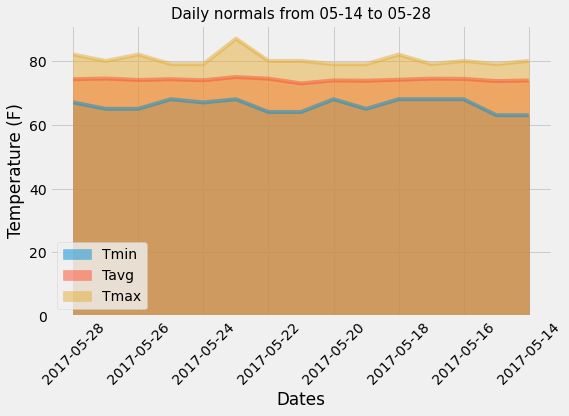

In [42]:
# Plot the daily normals as an area plot
vacation_df.plot.area(stacked = False, figsize = (8,5), rot = 45)
plt.ylabel("Temperature (F)")
plt.legend(loc = "best")
plt.title(f"Daily normals from {start_trip_date} to {end_trip_date}", fontsize = 15)